# Vanilla LSTM model with Penn Treebank

### Import packages

In [1]:
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from keras.utils import to_categorical

Using TensorFlow backend.


### Load data

In [2]:
#Tokenizer: splits sentences into char tokens
def tokenize(lines):
    return [line for line in lines]

# set up fields
TEXT = data.Field(lower=True, tokenize=tokenize, batch_first=True)

# make splits for data
train, valid, test = datasets.PennTreebank.splits(TEXT)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0])['text'][0:10])

# build the vocabulary
TEXT.build_vocab(train)

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))

# make iterator for splits
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test), batch_size=64, bptt_len=100)

# print batch information
batch = next(iter(train_iter))
#print(batch.text)
#print(batch.target)

train.fields {'text': <torchtext.data.field.Field object at 0x7f78fe99e1d0>}
len(train) 1
vars(train[0]) [' ', 'a', 'e', 'r', ' ', 'b', 'a', 'n', 'k', 'n']
len(TEXT.vocab) 51


### Activate cuda 

In [3]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


### Define network

In [4]:
#Set hyperparameters
hidden_dim = 1024
vocab_size = len(TEXT.vocab)
emb_dim = 128
num_epochs = 5
learning_rate = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = hidden_dim)
        
        # Output layer
        self.l_out = nn.Linear(in_features=hidden_dim, out_features=51, bias=False)
      
        # embed
        self.embed = nn.Embedding(num_embeddings = len(TEXT.vocab), embedding_dim = emb_dim)

    def forward(self, x):
        x = x.cuda()
        x = self.embed(x)
  
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)

        # Flatten output for feed-forward layer
        x = x.view(-1, hidden_dim)

        # Output layer
        x = self.l_out(x)
        
        return x

# Initialize a new network
net = Net()
net.cuda()
print(net)

Net(
  (lstm): LSTM(128, 1024)
  (l_out): Linear(in_features=1024, out_features=51, bias=False)
  (embed): Embedding(51, 128)
)


### Training loop

In [5]:
# Loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# Add learning rate decay
scheduler = StepLR(optimizer, step_size=4, gamma=0.85)

# Track loss
training_loss, validation_loss = [], []
loss_list = []

# For each epoch
for i in range(num_epochs):
    # Decay learning rate
    scheduler.step()
    print('Epoch:', i,'LR:', scheduler.get_lr())

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for batch in valid_iter:
        
        text = batch.text
        target = batch.target
        target = target.cuda()

        # Forward pass
        outputs = net(text)
        
        # Compute loss
        target = target.view(-1, target.shape[0]*target.shape[1])[0] 
        loss = criterion(outputs,target)
        
        # Update loss
        epoch_validation_loss += loss.detach().cpu().data.numpy()
    
    net.train()
    
    # For each sentence in training set
    for batch in train_iter:

        text = batch.text
        target = batch.target
        target = target.cuda()
        
        # Forward pass
        outputs = net(text)
        
        # Compute loss
        target = target.view(-1, target.shape[0]*target.shape[1])[0]
        loss = criterion(outputs,target) 

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
              
        # Update loss
        epoch_training_loss += loss.detach().cpu().data.numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss / len(vars(train[0])['text'])) 
    validation_loss.append(epoch_validation_loss / len(vars(valid[0])['text']))

    # Print loss every
    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch: 0 LR: [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0, training loss: 0.0002009437421083159, validation loss: 0.0006195691795375266
Epoch: 1 LR: [0.01]
Epoch 1, training loss: 0.00018000329015651286, validation loss: 0.00018952757126245253
Epoch: 2 LR: [0.01]
Epoch 2, training loss: 0.000184389497700235, validation loss: 0.00018893811740311602
Epoch: 3 LR: [0.0085]
Epoch 3, training loss: 0.00018287062297865715, validation loss: 0.00019662402469125412
Epoch: 4 LR: [0.0085]
Epoch 4, training loss: 0.00018581301247694534, validation loss: 0.0001880122217716062


### Test loop

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


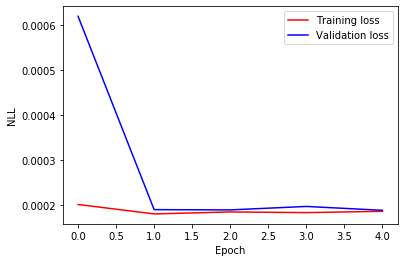

mean of BPC: 1.8758946034644368


In [6]:
# Get first sentence in test set
loss_list = []
BPC_list = []
j=0

for batch in test_iter:
    text, target = batch.text.cuda(), batch.target.cuda()
    outputs = net.forward(text)
    target = target.view(-1, target.shape[0]*target.shape[1])[0]

    #Update loss
    loss = criterion(outputs, target)
    loss_list.append(loss)

    outputs_softmax = softmax(outputs)

    output_softmax_array = outputs_softmax.cpu().data.numpy()
    target_array = target.cpu().data.numpy()
    summation = 0
    for i in range(0,len(target_array)):
      prob_of_true = output_softmax_array[i][target_array[i]]
      summation += np.log2(prob_of_true)
    BPC_list.append(- 1 / len(target_array) * summation)
    j += 1
    if j == 50:
      break

    #To avoid running out of memeory
    del target
    del loss
    del outputs

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

print('mean of BPC:', np.mean(BPC_list))

### Predicit

In [7]:
output_array = outputs.cpu().data.numpy()
target_array = target.cpu().data.numpy()

for j in range(0,10):
  for i in range(j,len(output_array),64):
    #predict
    char_vector = output_array[i]
    char = np.argmax(char_vector)
    predict_char = TEXT.vocab.itos[char]

    # True
    char = target_array[i]
    true_char = TEXT.vocab.itos[char]
    
    print(true_char, predict_char, sep='\t')

s	 
 	 
u	<eos>
p	n
 	 
s	t
a	a
i	i
d	d
 	 
o	t
n	n
e	 
 	 
m	t
a	a
j	r
o	o
r	r
 	 
s	a
p	t
e	e
c	n
i	i
a	f
l	l
i	 
s	s
t	t
 	s
<eos>	<eos>
 	 
t	t
h	h
i	e
s	s
 	 
c	w
o	o
n	m
f	t
u	e
s	s
i	i
o	t
n	n
 	 
e	t
f	x
f	f
e	e
c	c
t	t
i	 
v	v
e	e
l	 
y	y
 	 
h	a
a	a
l	d
t	f
e	 
d	r
 	 
o	a
n	n
e	 
 	 
f	t
o	o
r	r
m	 
 	e
o	t
f	f
 	 
p	t
r	r
o	e
g	f
r	r
a	a
m	m
 	 
t	t
r	r
a	a
d	d
i	i
n	n
g	g
 	 
s	t
t	a
o	o
c	c
k	k
 	 
a	t
s	n
 	 
r	t
e	e
p	l
r	o
e	e
s	s
e	i
n	n
t	t
i	a
n	a
g	g
 	 
n	t
 	o
n	n
 	 
o	t
f	f
 	 
t	t
h	h
e	e
 	 
v	s
a	e
l	l
u	u
e	e
 	 
o	o
f	f
 	 
a	t
l	 
l	l
 	 
h	t
o	e
o	u
k	k
e	l
r	r
 	s
r	<eos>
e	e
a	s
l	l
-	 
e	b
s	a
t	s
a	i
t	t
e	e
 	 
h	a
o	a
l	u
d	d
i	i
n	n
g	g
s	 
 	 
i	<eos>
n	n
 	 
t	t
h	h
e	e
 	 
u	s
.	.
s	s
.	.
 	 
<eos>	m
 	 
n	t
o	e
t	t
 	 
i	t
n	n
c	 
l	.
u	u
d	d
e	i
d	d
 	 
i	t
n	t
 	 
t	t
>	>
 	 
a	a
t	n
 	 
t	t
w	h
i	o
c	n
e	 
 	 
t	<eos>
h	h
e	e
 	 
n	s
o	 
r	t
m	t
a	a
l	l
 	 
w	b
e	a
e	e
k	k
e	 
n	n
d	 
 	 
p	t
a	r
c	c
e	k
 	 
y	a
e	e
s	s
t	t
e	e
r	r
d	d
a	a


### Freestyle

In [8]:
input_text = 'i think you are'
input_text = list(input_text)

text_numeric = []

for char in input_text:
  text_numeric.append(TEXT.vocab.stoi[char])
  
input_array = np.array(text_numeric)

exp_dim = len(input_array)

input_tensor = torch.from_numpy(input_array)
input_tensor = input_tensor.expand(1,exp_dim)
input_tensor = input_tensor.view(exp_dim,-1)

outputs = net.forward(input_tensor)

values, indices = outputs[-1].max(0)

input_array = np.append(input_array, indices.cpu().numpy())

for i in range(100):
  exp_dim = len(input_array)
  input_tensor = torch.from_numpy(input_array)

  input_tensor = input_tensor.expand(1,exp_dim)
  input_tensor = input_tensor.view(exp_dim,-1)
  outputs = net.forward(input_tensor)

  values, indices = outputs[-1].max(0)

  input_array = np.append(input_array, indices.cpu().numpy())

predicted_sentence = list() 
for char in input_array:
  predict_char = TEXT.vocab.itos[char]
  predicted_sentence.append(predict_char)

print(''.join(predicted_sentence))

i think you are n't eatly a <unk> <eos> the state of the state of the state of the state of the state of the state of th
